In [1]:
from google.colab import files
uploaded = files.upload()


Saving sp_400_midcap1.csv to sp_400_midcap1.csv


In [2]:
import requests
import pandas as pd

class StockData:
    """
    A class to fetch and process stock data from the EOD Historical Data API.
    """
    def __init__(self, csv_file_path: str, api_key: str) -> None:
        """
        Initialize the StockData object by loading ticker symbols and sectors from a CSV file.
        """
        # Load ticker names and sectors from the uploaded CSV file
        self.ticker_names = pd.read_csv(csv_file_path)['Symbol'].tolist()
        self.ticker_sectors = pd.read_csv(csv_file_path)['GICS Sector'].tolist()
        self.ticker_info = dict(zip(self.ticker_names, self.ticker_sectors))
        self.api_key = api_key
        self.base_url = 'https://eodhd.com/api/eod'

    def _fetch_data(self, ticker: str, period: str, start: str, end: str):
        '''
        Private method to fetch stock data for a single ticker symbol from the API.
        '''
        url = f"{self.base_url}/{ticker}.US?period={period}&from={start}&to={end}&api_token={self.api_key}&fmt=json"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to fetch data for {ticker}: {response.status_code}")
            return None

    def fetch_stock(self, ticker: str, period: str, start: str, end: str) -> pd.DataFrame:
        """
        Fetches stock data for a single ticker and returns it as a pandas DataFrame.
        """
        print(f"Fetching data for {ticker}...")
        result = self._fetch_data(ticker, period, start, end)
        df = pd.DataFrame(result)
        return df

    def fetch_stocks_by_sectors(self, sector: str, period: str, start: str, end: str) -> pd.DataFrame:
        """
        Fetches stock data for all tickers in a specific GICS sector and returns a merged DataFrame.
        """
        results = {}
        for ticker, s in self.ticker_info.items():
            if s == sector:
                results[ticker] = pd.DataFrame(self._fetch_data(ticker, period, start, end))

        all_data = self._process_merge_all_data(results)
        return all_data

    def fetch_all_stocks(self, period: str, start: str, end: str):
        '''
        Fetches stock data for all tickers and returns a merged DataFrame.
        '''
        results = {}
        for ticker in self.ticker_info.keys():
            results[ticker] = pd.DataFrame(self._fetch_data(ticker, period, start, end))

        all_data = self._process_merge_all_data(results)
        return all_data

    def _process_merge_all_data(self, dic:dict) -> pd.DataFrame:
        '''
        Private method to process and merge stock data from multiple tickers into a single DataFrame.
        '''
        all_data = []

        for name, df in dic.items():
            if df.empty:
                print(f"No data for {name}. Skipping...")
                continue

            df['date'] = pd.to_datetime(df['date'])
            df['ticker'] = name
            all_data.append(df)

        full_data = pd.concat(all_data)

        full_data.set_index(['date', 'ticker'], inplace=True)

        return full_data


# Run the code in the main block
if __name__ == "__main__":
    # Use the name of the uploaded file
    csv_file_path = "sp_400_midcap1.csv"  # Ensure this matches the name of the uploaded file
    api_key = '662166cb8e3d13.57537943'  # Replace with your actual API key

    # Initialize StockData with uploaded CSV file path and API key
    stock = StockData(csv_file_path, '662166cb8e3d13.57537943')

    # Fetch all stock data (example)
    df = stock.fetch_all_stocks(period='d', start='2000-01-01', end='2024-08-30')
    print(df.head())
    print(df.shape)


                      open     high      low    close  adjusted_close   volume
date       ticker                                                             
2000-01-03 AA      83.0000  83.5624  80.3750  80.9375         69.8640  1291386
2000-01-04 AA      80.9375  81.8125  80.3125  81.3125         70.1877  1860008
2000-01-05 AA      81.3125  86.5000  81.0000  86.0000         74.2338  2598086
2000-01-06 AA      86.0000  86.3750  84.8125  84.8750         73.2627  3740907
2000-01-07 AA      84.8750  86.8750  84.5624  84.6250         73.0469  3774199
(1965472, 6)


In [3]:
from google.colab import files
uploaded = files.upload()  # Upload the 'sp_400_midcap1.csv' file

import pandas as pd

# Step 1: Automatically set `sector_info_path` to the uploaded file's name
sector_info_path = list(uploaded.keys())[0]  # Get the filename dynamically

# Assuming `df` is the DataFrame that contains your stock data with 'date' and 'ticker' indices

# Reset the index without adding duplicate index columns
df = df.reset_index()

# Read the sector information from the uploaded file
sector_info = pd.read_csv(sector_info_path)

# Select only the 'Symbol' and 'GICS Sector' columns
sector_info = sector_info[['Symbol', 'GICS Sector']]

# Merge on 'ticker' in df and 'Symbol' in sector_info
df_merged = pd.merge(df, sector_info, left_on='ticker', right_on='Symbol', how='left')

# Drop the redundant 'Symbol' column after merging
df_merged = df_merged.drop(columns=['Symbol'])

Saving sp_400_midcap1.csv to sp_400_midcap1 (1).csv


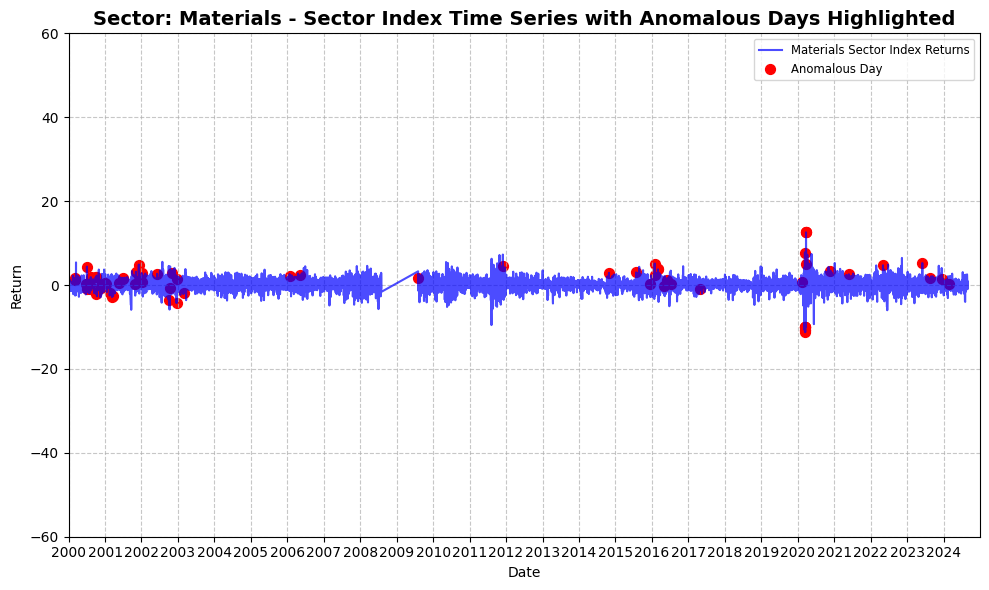

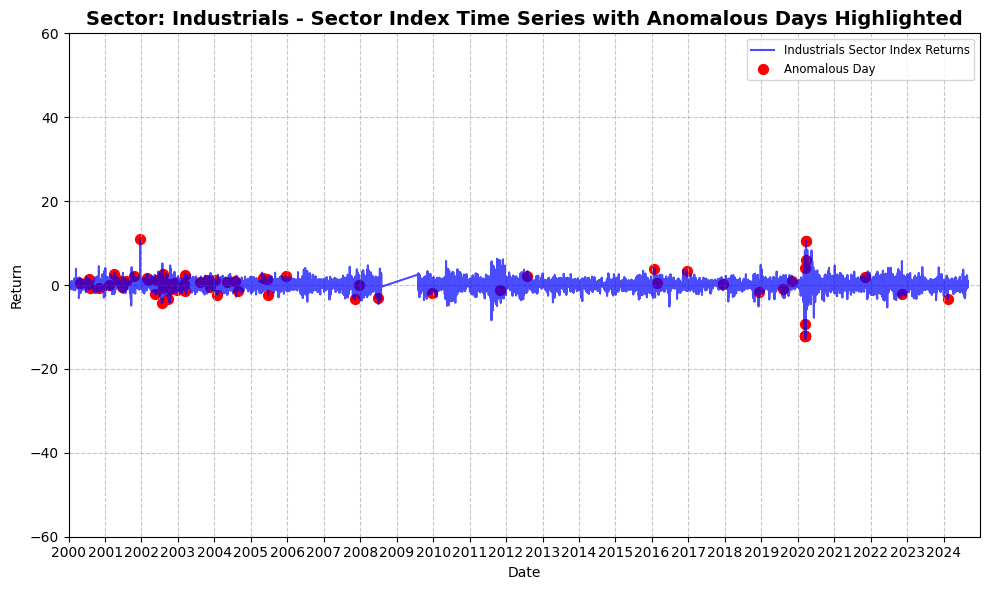

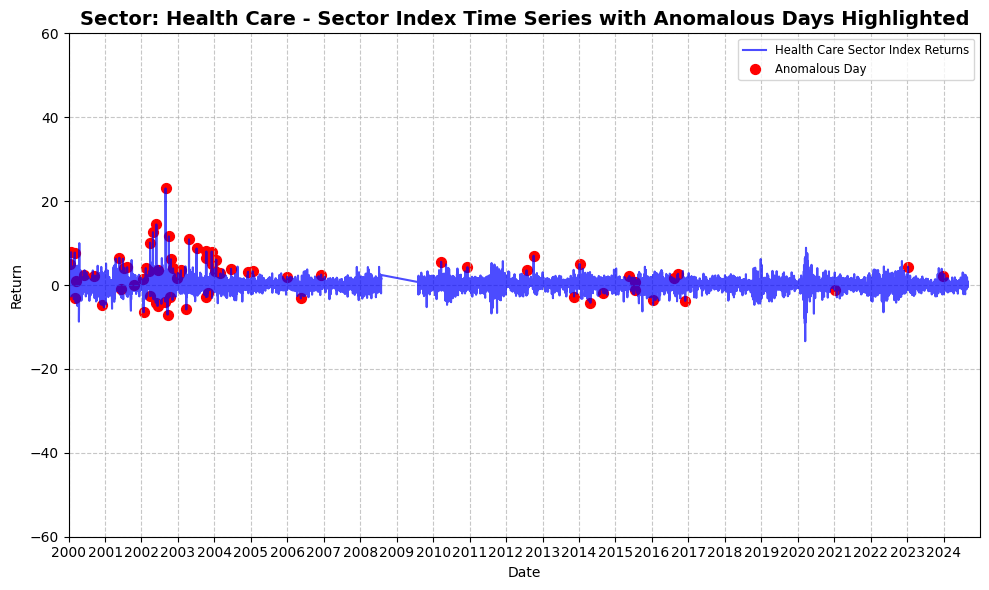

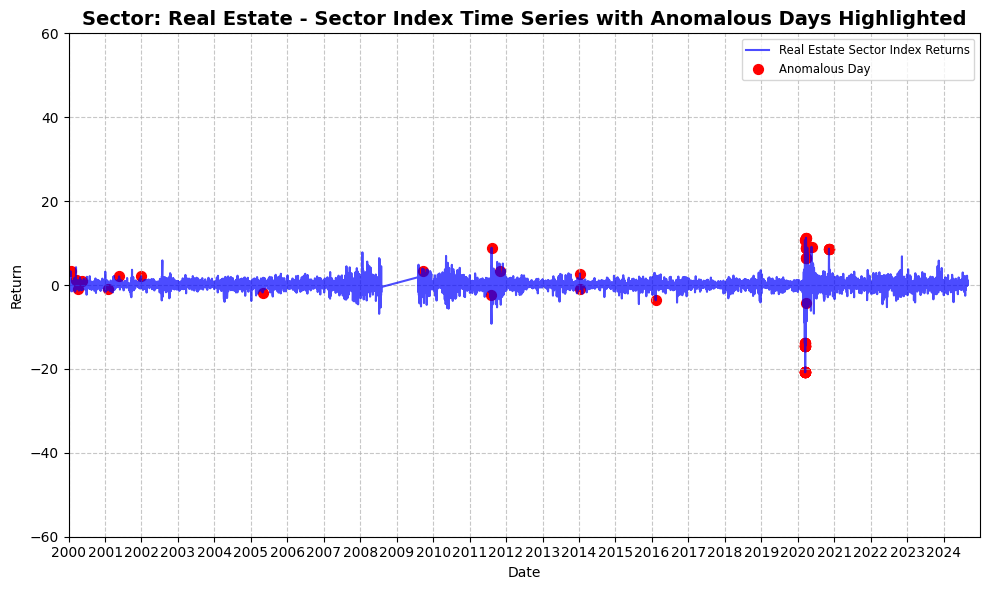

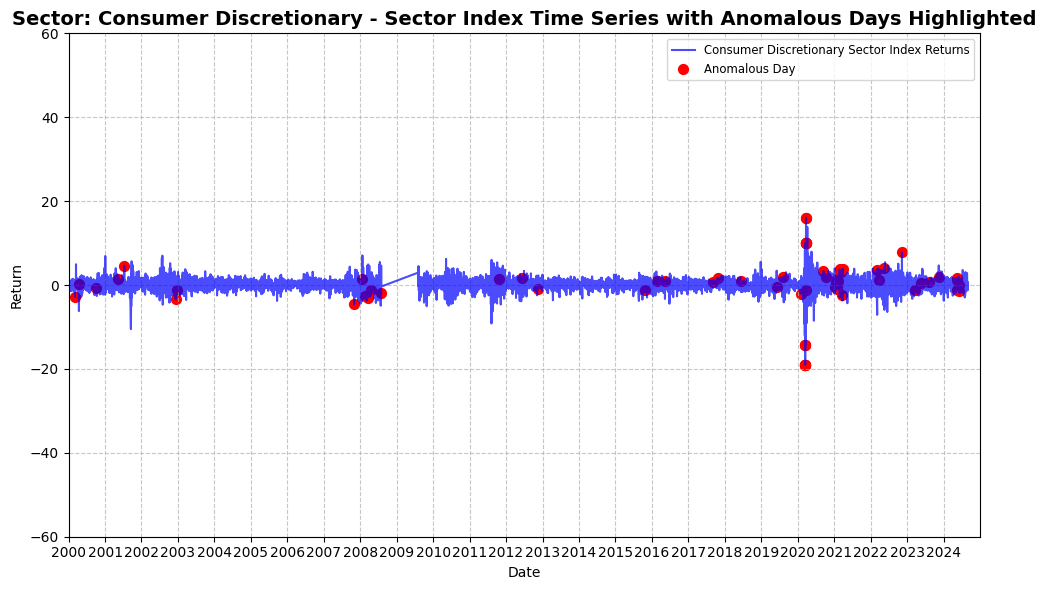

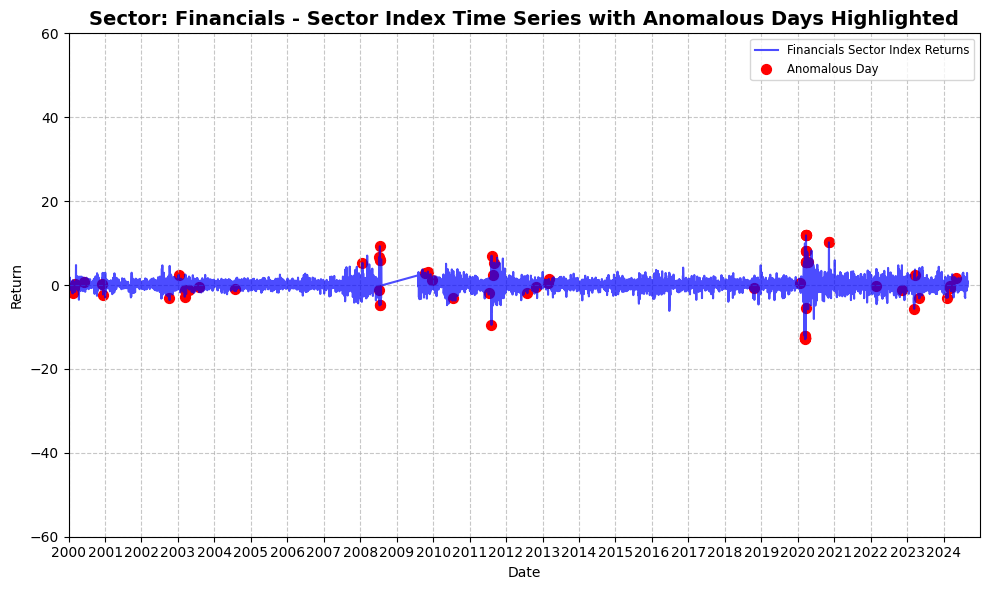

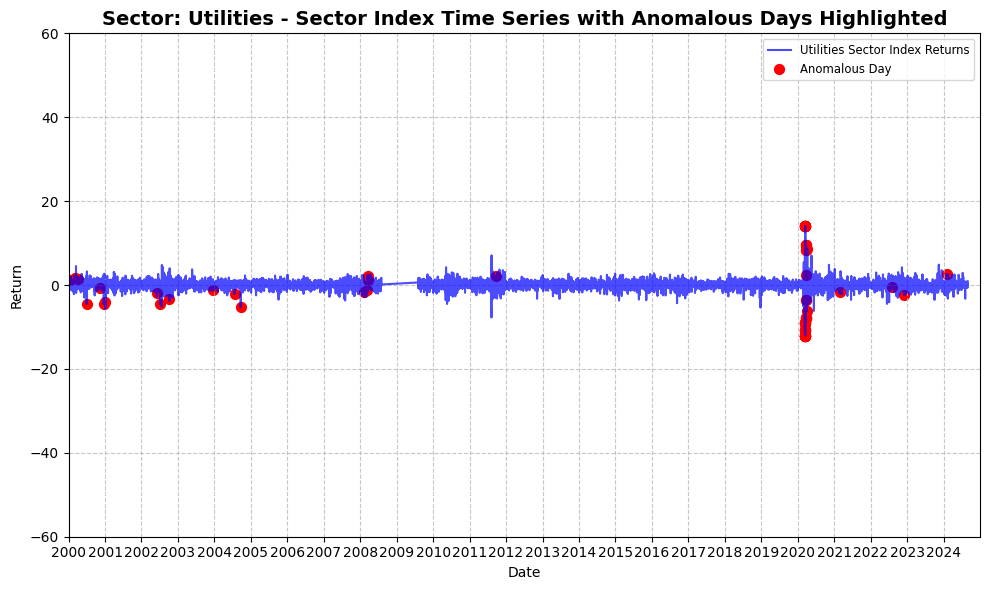

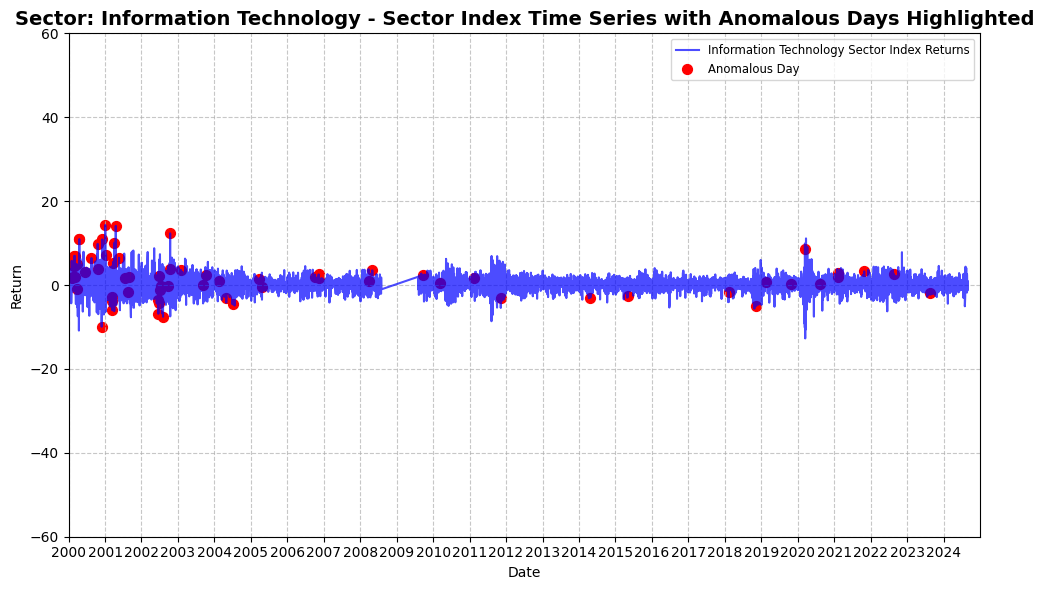

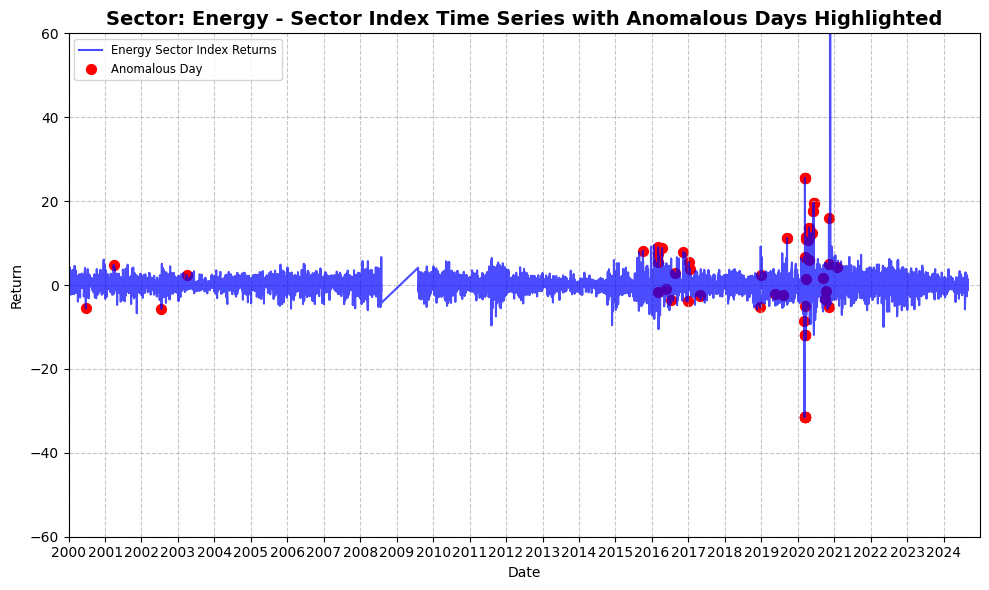

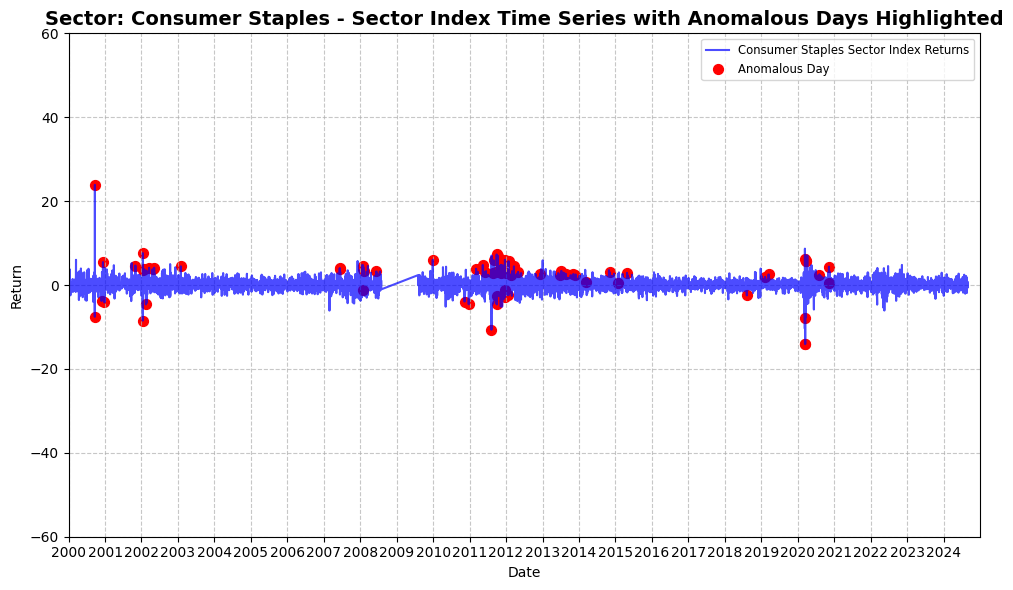

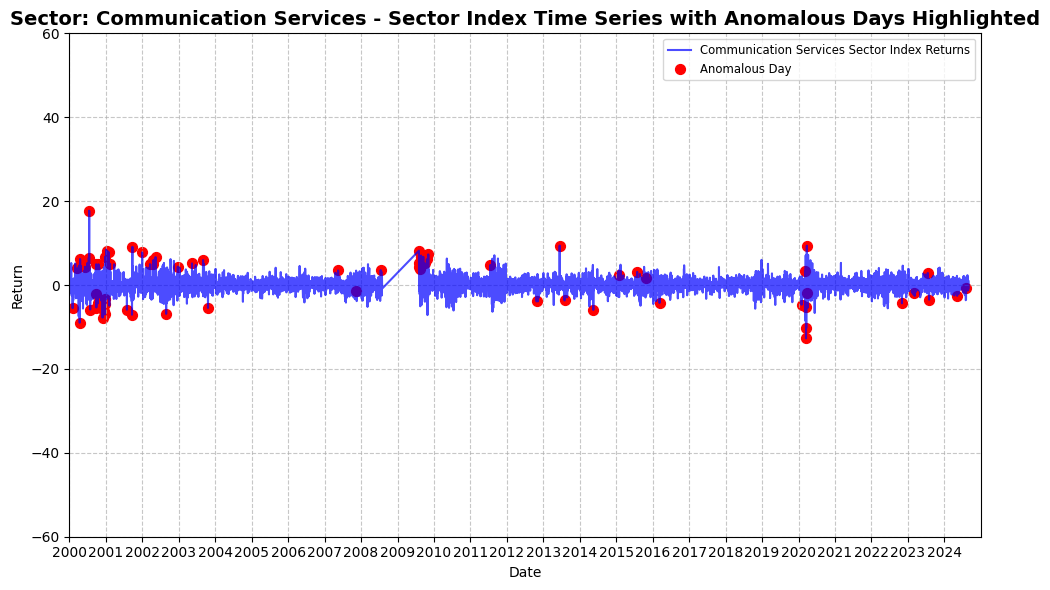

Anomalies data saved to 'all_anomalies_excluded_period.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import mahalanobis

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged.dropna(subset=['date'], inplace=True)

# Calculate daily returns for each stock
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Define the exclusion period
exclusion_start = pd.Timestamp('2008-08-01')
exclusion_end = pd.Timestamp('2009-08-01')

# Function to calculate stable mean and covariance for the entire sector
def calculate_stable_mean_cov(sector_df):
    sector_returns = sector_df.pivot(index='date', columns='ticker', values='return').dropna()
    mean_vector = sector_returns.mean().values
    cov_matrix = np.cov(sector_returns.T)
    cov_inv = np.linalg.inv(cov_matrix)
    return mean_vector, cov_inv, sector_returns.columns

# Function to calculate anomalies using the stable mean and covariance across pairs
def calculate_multidimensional_anomalies(sector_df, mean_vector, cov_inv, sector_columns):
    anomalies = []

    for ticker in sector_columns:
        # Filter out the exclusion period
        ticker_df = sector_df[(sector_df['ticker'] == ticker) &
                              ~((sector_df['date'] >= exclusion_start) & (sector_df['date'] <= exclusion_end))].dropna(subset=['return'])

        if ticker_df.empty:
            continue  # Skip if no data for the ticker

        # Calculate Mahalanobis distance for each return against the stable sector mean
        ticker_df['anomaly_score'] = ticker_df['return'].apply(
            lambda x: mahalanobis([x], mean_vector, cov_inv)
        )

        anomalies.append(ticker_df[['date', 'ticker', 'anomaly_score']])

    # Combine all anomalies and sort by score
    all_anomalies = pd.concat(anomalies).sort_values(by='anomaly_score', ascending=False)

    # Select the top 70 highest anomalies
    top_anomalies = all_anomalies.nlargest(70, 'anomaly_score')

    return top_anomalies

# Prepare to collect anomalies for plotting and final output
top_anomalies_per_sector = {}

# Calculate anomalies for each sector by analyzing stock pairs
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    stable_mean, stable_cov_inv, sector_columns = calculate_stable_mean_cov(sector_df)

    top_sector_anomalies = calculate_multidimensional_anomalies(sector_df, stable_mean, stable_cov_inv, sector_columns)
    top_anomalies_per_sector[sector] = top_sector_anomalies  # Store top anomalies for this sector

# Aggregate daily returns for each sector excluding the specified period
sector_daily_returns = {}
for sector, sector_df in df_merged.groupby('GICS Sector'):
    # Filter out dates in the exclusion period
    sector_df = sector_df[(sector_df['date'] < exclusion_start) | (sector_df['date'] > exclusion_end)]
    sector_df = sector_df.pivot_table(index='date', values='return', aggfunc='mean')
    sector_daily_returns[sector] = sector_df

# Save all anomalies to a CSV file
all_anomalies_combined = pd.concat(top_anomalies_per_sector.values())
all_anomalies_combined.to_csv("all_anomalies_excluded_period.csv", index=False)

# Plot each sector's time series and mark anomalies
for sector, top_anomalies in top_anomalies_per_sector.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"Sector: {sector} - Sector Index Time Series with Anomalous Days Highlighted", fontsize=14, fontweight='bold')

    # Plot the sector's average daily return time series as a sector index
    sector_df = sector_daily_returns[sector]
    plt.plot(sector_df.index, sector_df['return'], color='blue', alpha=0.7, label=f'{sector} Sector Index Returns')

    # Highlight anomaly dates on the sector time series
    anomaly_dates = top_anomalies['date'].unique()  # Unique anomaly dates
    anomaly_scores = top_anomalies[top_anomalies['date'].isin(anomaly_dates)]
    plt.scatter(anomaly_scores['date'], sector_df.loc[anomaly_scores['date'], 'return'], color='red', s=50, label='Anomalous Day')

    # Customize each plot
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2024-12-31')])
    plt.ylim(-60, 60)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add a legend
    plt.legend(loc='best', fontsize='small')

    # Adjust layout for neat spacing
    plt.tight_layout()
    plt.show()

# Display a message to inform the user
print("Anomalies data saved to 'all_anomalies_excluded_period.csv'.")

# For Google Colab, you can add this to download the file directly
from google.colab import files
files.download("all_anomalies_excluded_period.csv")


In [8]:
from google.colab import files
files.download("anomaly_indicator.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
print("All anomalies across sectors (stock name, date, and anomaly score):")
for sector, top_anomalies in top_anomalies_per_sector.items():
    print(f"\nSector: {sector}")
    print(top_anomalies)



All anomalies across sectors (stock name, date, and anomaly score):

Sector: Materials
             date ticker  anomaly_score
745350 2008-10-10    GPK      81.855646
149470 2002-12-18   AVNT      63.415344
286793 2001-12-05    CCK      57.118754
286773 2001-11-06    CCK      55.526761
743270 2000-07-03    GPK      51.957000
...           ...    ...            ...
368092 2011-11-28    CMC      29.911914
745354 2008-10-16    GPK      29.906381
356603 2015-07-28    CLF      29.904904
743295 2000-08-08    GPK      29.673610
285167 2020-02-14     CC      29.630799

[70 rows x 3 columns]

Sector: Industrials
              date ticker  anomaly_score
713570  2001-12-19    GGG     872.072913
717344  2016-12-15    GGG     313.898936
714577  2005-12-19    GGG     302.060760
715331  2008-12-17    GGG     300.519372
864739  2011-11-01    ITT     231.289079
...            ...    ...            ...
612297  2002-07-25    FCN      46.977180
1692978 2008-10-24    TKR      46.863904
639864  2001-05-10  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All anomalies across sectors (stock name, date, and anomaly score):

Sector: Materials
              date ticker  anomaly_score
149470  2002-12-18   AVNT      63.179096
286793  2001-12-05    CCK      56.903146
286773  2001-11-06    CCK      55.317125
743270  2000-07-03    GPK      51.760755
356815  2016-05-31    CLF      49.536774
...            ...    ...            ...
278398  2002-06-07    CBT      27.402168
356734  2016-02-03    CLF      27.327865
1434578 2020-03-18   RGLD      27.159615
163812  2020-03-16   AXTA      26.793013
998997  2002-10-02    LPX      26.782057

[70 rows x 3 columns]

Sector: Industrials
              date ticker  anomaly_score
713570  2001-12-19    GGG     872.852124
717344  2016-12-15    GGG     314.184230
714577  2005-12-19    GGG     302.335579
864739  2011-11-01    ITT     231.501274
264673  2021-11-02    CAR     168.623681
...            ...    ...            ...
263239  2016-02-24    CAR      41.385260
359290  2001-08-01    CLH      41.207878
656783  

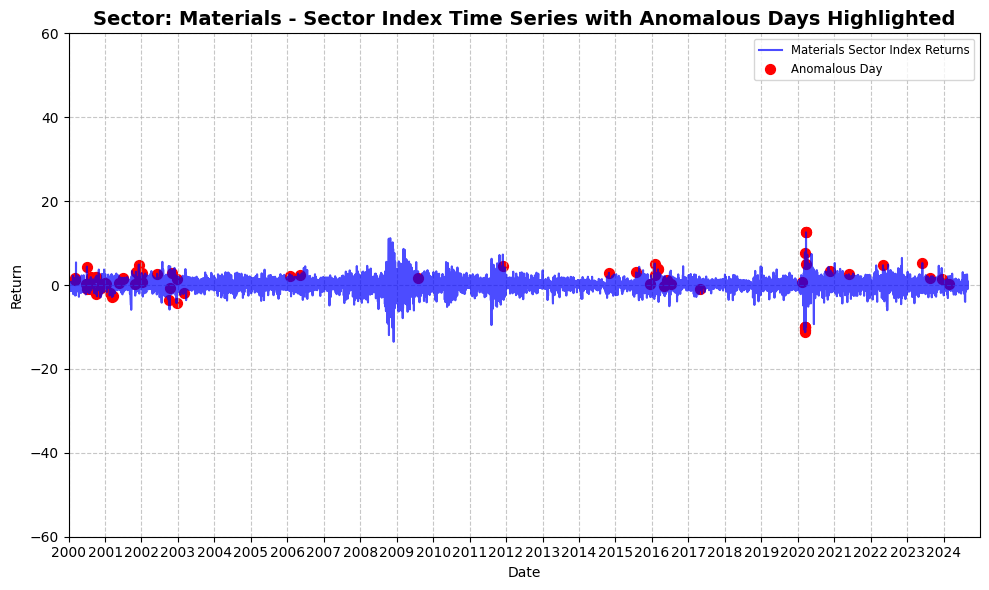

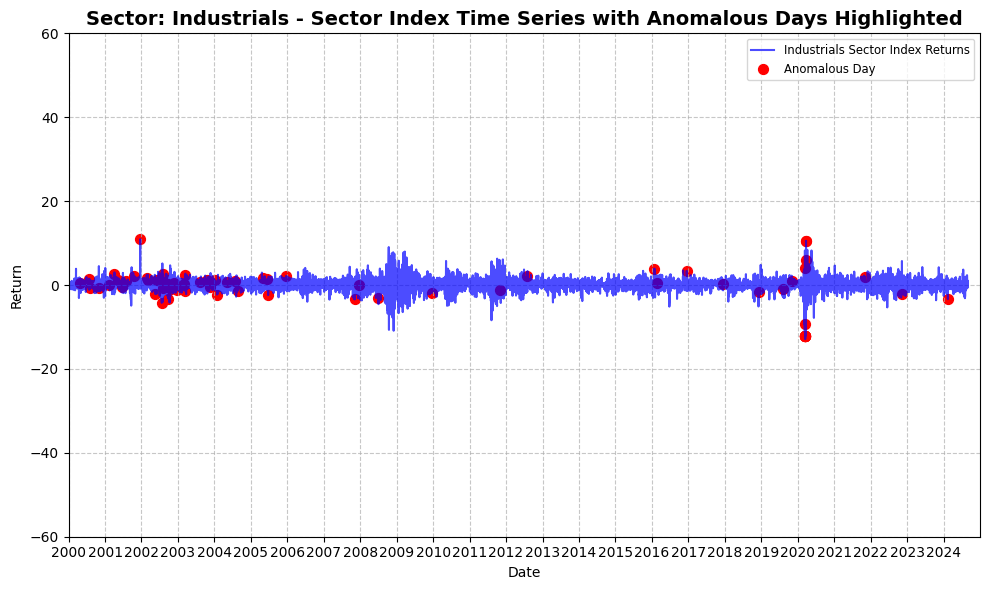

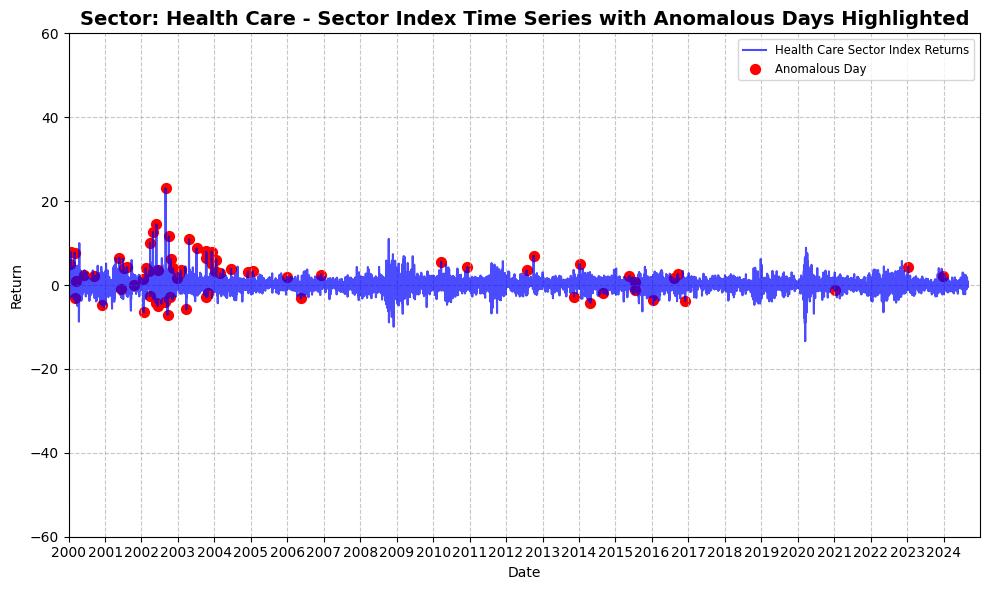

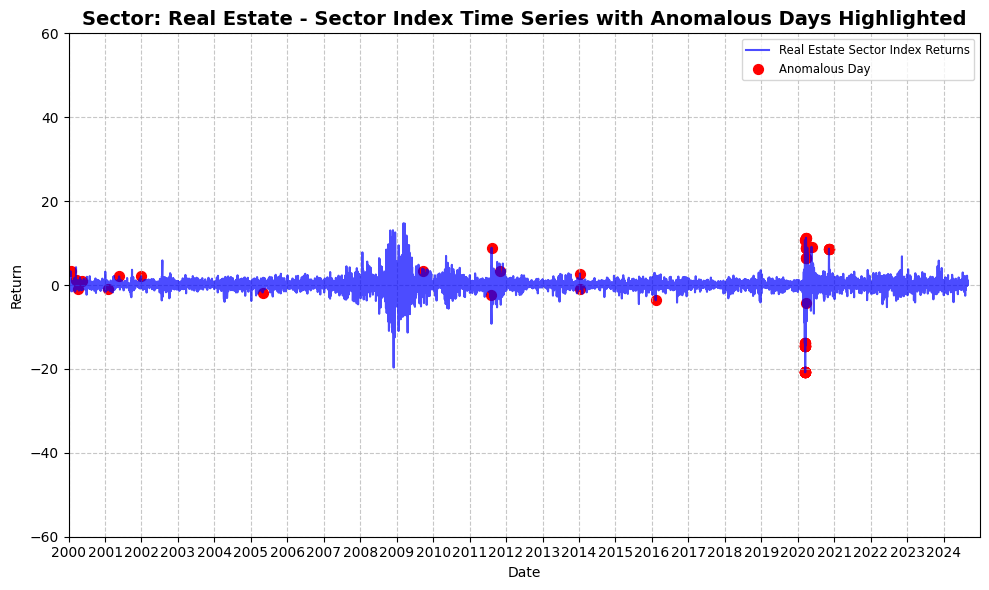

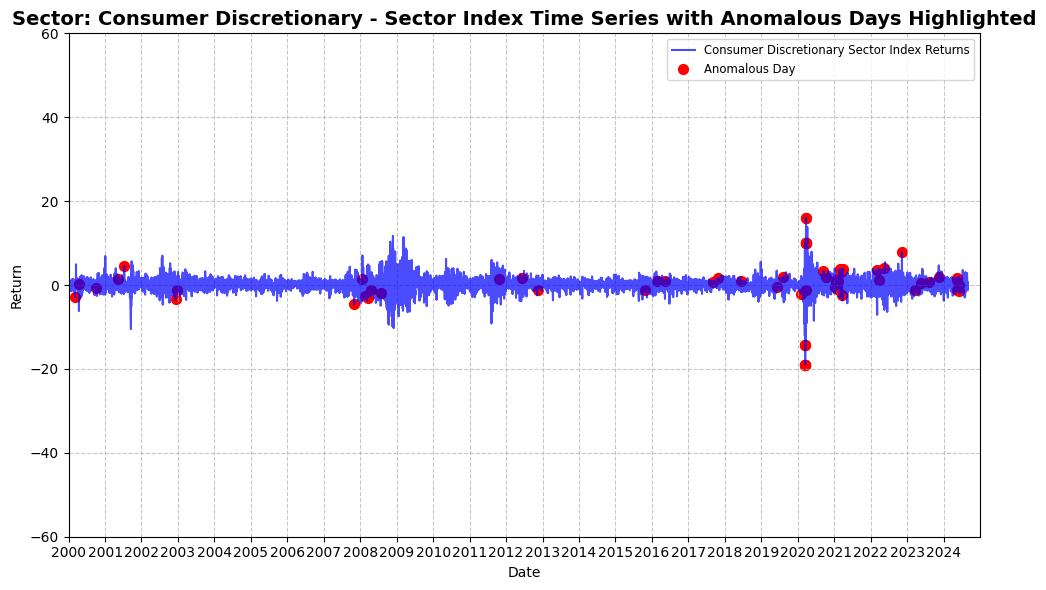

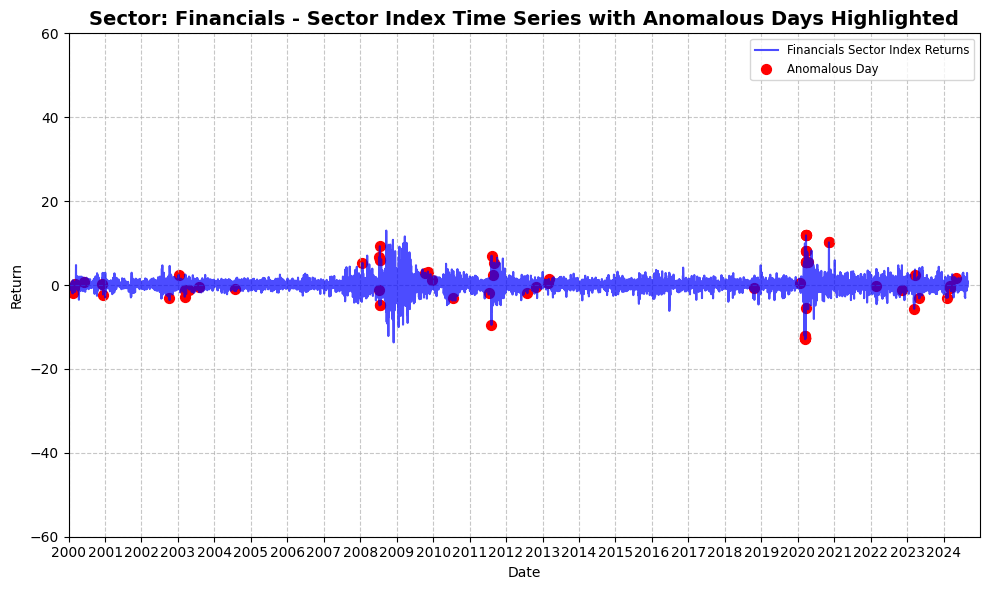

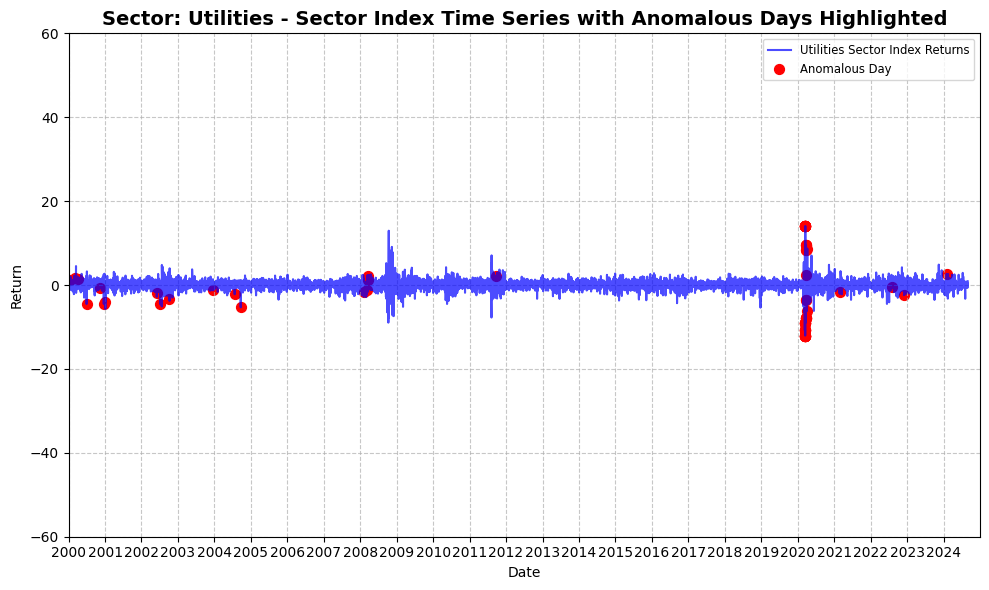

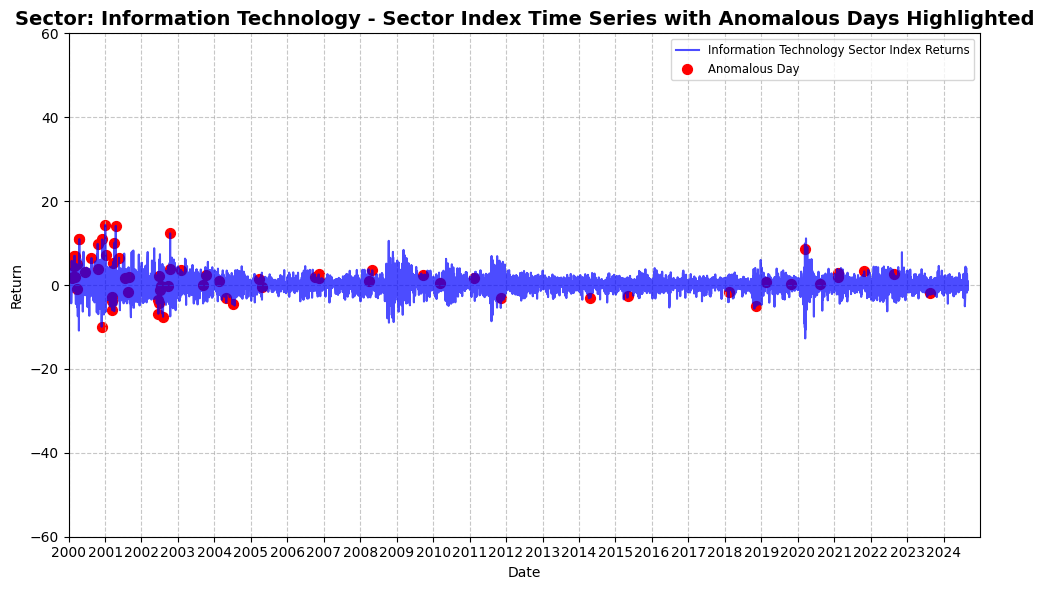

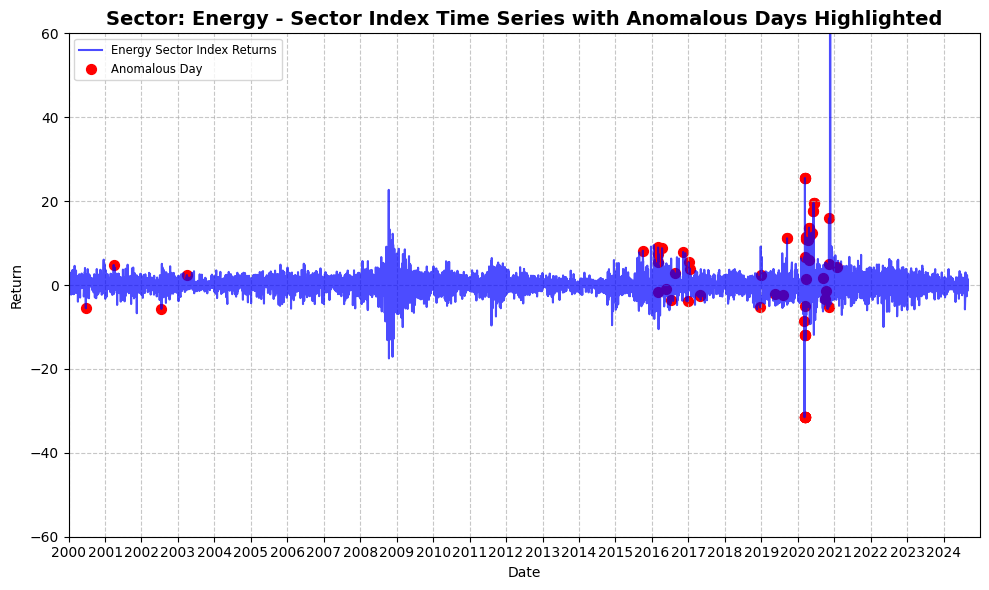

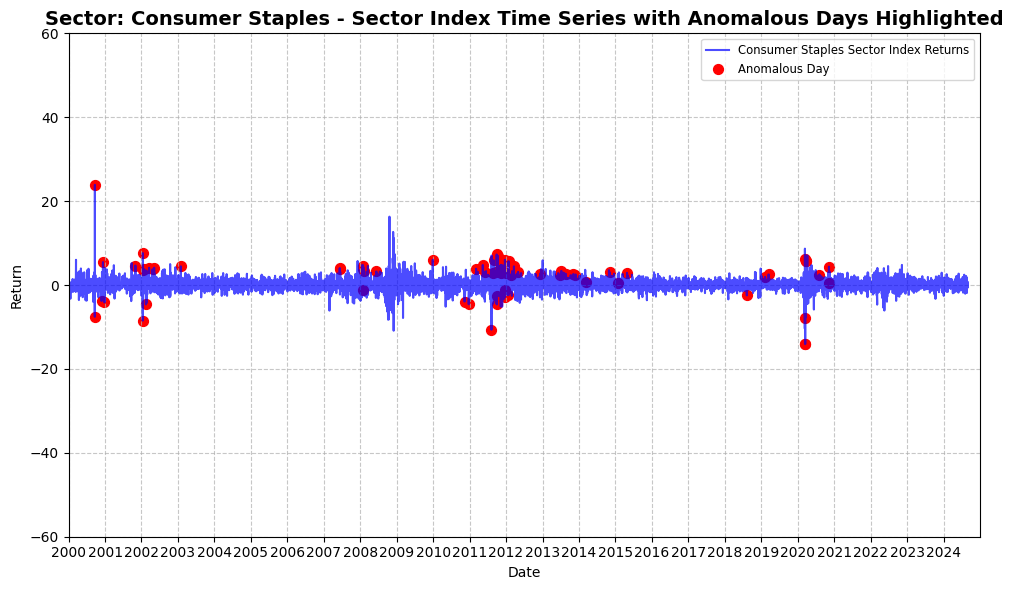

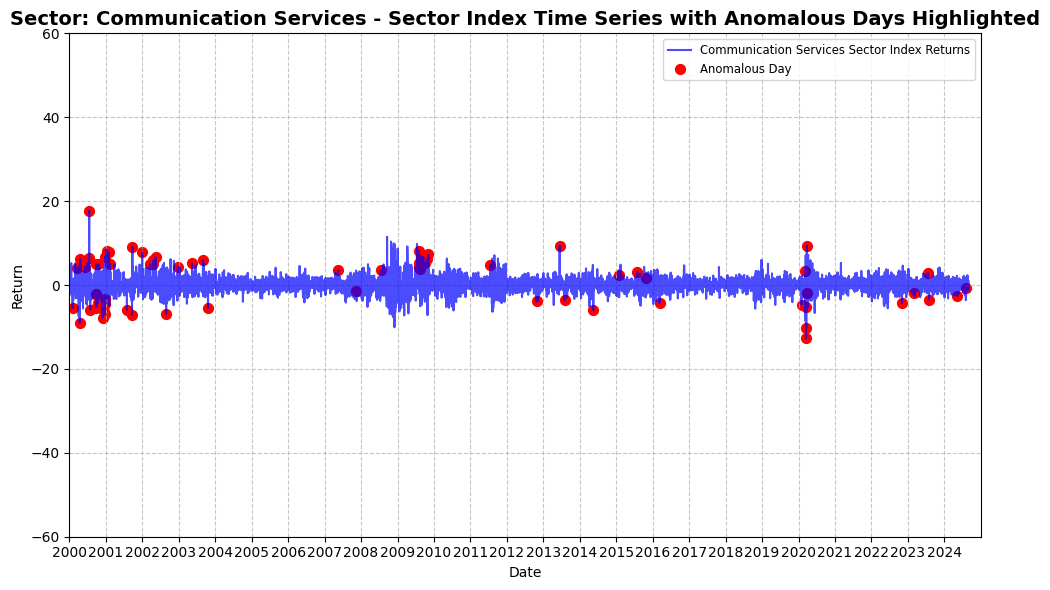

Sector-based anomaly summary saved to 'sector_anomalies_summary.csv'.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import mahalanobis

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged.dropna(subset=['date'], inplace=True)

# Calculate daily returns for each stock
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Define the exclusion period
exclusion_start = pd.Timestamp('2008-08-01')
exclusion_end = pd.Timestamp('2009-08-01')

# Function to calculate stable mean and covariance for the entire sector
def calculate_stable_mean_cov(sector_df):
    sector_returns = sector_df.pivot(index='date', columns='ticker', values='return').dropna()
    mean_vector = sector_returns.mean().values
    cov_matrix = np.cov(sector_returns.T)
    cov_inv = np.linalg.inv(cov_matrix)
    return mean_vector, cov_inv, sector_returns.columns

# Function to calculate anomalies using the stable mean and covariance across pairs
def calculate_multidimensional_anomalies(sector_df, mean_vector, cov_inv, sector_columns):
    anomalies = []

    for ticker in sector_columns:
        # Filter out the exclusion period
        ticker_df = sector_df[(sector_df['ticker'] == ticker) &
                              ~((sector_df['date'] >= exclusion_start) & (sector_df['date'] <= exclusion_end))].dropna(subset=['return'])

        if ticker_df.empty:
            continue  # Skip if no data for the ticker

        # Calculate Mahalanobis distance for each return against the stable sector mean
        ticker_df['anomaly_score'] = ticker_df['return'].apply(
            lambda x: mahalanobis([x], mean_vector, cov_inv)
        )

        anomalies.append(ticker_df[['date', 'ticker', 'anomaly_score']])

    # Combine all anomalies and sort by score
    all_anomalies = pd.concat(anomalies).sort_values(by='anomaly_score', ascending=False)

    # Select the top 70 highest anomalies
    top_anomalies = all_anomalies.nlargest(70, 'anomaly_score')

    return top_anomalies

# Prepare to collect anomalies for each sector
top_anomalies_per_sector = {}

# Calculate anomalies for each sector
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    stable_mean, stable_cov_inv, sector_columns = calculate_stable_mean_cov(sector_df)

    top_sector_anomalies = calculate_multidimensional_anomalies(sector_df, stable_mean, stable_cov_inv, sector_columns)
    top_anomalies_per_sector[sector] = top_sector_anomalies  # Store top anomalies for this sector

# Create a date range covering the full period in the dataset
date_range = pd.date_range(start=df_merged['date'].min(), end=df_merged['date'].max())

# Initialize an empty DataFrame for the sector-based anomaly summary
sector_anomalies_summary = pd.DataFrame(index=date_range)

# Populate the DataFrame: 1 for anomaly, 0 for no anomaly
for sector, anomalies in top_anomalies_per_sector.items():
    # Mark anomalies for this sector as 1, non-anomalies as 0
    sector_anomalies_summary[sector] = 0
    anomaly_dates = anomalies['date'].unique()
    sector_anomalies_summary.loc[anomaly_dates, sector] = 1

# Save to CSV
sector_anomalies_summary.to_csv("sector_anomalies_summary.csv")

# For Google Colab, you can add this to download the file directly
from google.colab import files
files.download("sector_anomalies_summary.csv")

# Display all anomalies with stock name, date, and anomaly score for each sector
print("All anomalies across sectors (stock name, date, and anomaly score):")
for sector, anomalies in top_anomalies_per_sector.items():
    print(f"\nSector: {sector}")
    print(anomalies)

# Plot each sector's time series and mark anomalies
for sector, top_anomalies in top_anomalies_per_sector.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"Sector: {sector} - Sector Index Time Series with Anomalous Days Highlighted", fontsize=14, fontweight='bold')

    # Aggregate sector returns for sector index plot
    sector_df = df_merged[df_merged['GICS Sector'] == sector]
    sector_daily_return = sector_df.pivot_table(index='date', values='return', aggfunc='mean')

    # Plot the sector's average daily return time series as a sector index
    plt.plot(sector_daily_return.index, sector_daily_return['return'], color='blue', alpha=0.7, label=f'{sector} Sector Index Returns')

    # Highlight anomaly dates on the sector time series
    plt.scatter(top_anomalies['date'], sector_daily_return.loc[top_anomalies['date'], 'return'],
                color='red', s=50, label='Anomalous Day')

    # Customize each plot
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2024-12-31')])
    plt.ylim(-60, 60)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add a legend
    plt.legend(loc='best', fontsize='small')

    # Adjust layout for neat spacing
    plt.tight_layout()
    plt.show()

# Display a message to inform the user
print("Sector-based anomaly summary saved to 'sector_anomalies_summary.csv'.")
